## **GPU**

In [ ]:
!nvidia-smi

Sun Apr 23 14:29:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Install**

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.1 MB/s eta 0:00:00


# **Imports** 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import random
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset**

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                          Spotify and Youtube                                   9MB  2023-03-20 15:43:25           9116        333  1.0              
arnabchaki/data-science-salaries-2023                          Data Science Salaries 2023  💸                        25KB  2023-04-13 09:55:16           2475         68  1.0              
erdemtaha/cancer-data                                          Cancer Data                                          49KB  2023-03-22 07:57:00           4227         97  1.0              
evangower/premier-league-2022-2023                             Pr

In [ ]:
!kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed

100% 4.15G/4.16G [00:34<00:00, 184MB/s]
100% 4.16G/4.16G [00:34<00:00, 129MB/s]


In [ ]:
!unzip '/content/traffic-signs-preprocessed.zip'

Archive:  /content/traffic-signs-preprocessed.zip
  inflating: data0.pickle            
  inflating: data1.pickle            
  inflating: data2.pickle            
  inflating: data3.pickle            
  inflating: data4.pickle            
  inflating: data5.pickle            
  inflating: data6.pickle            
  inflating: data7.pickle            
  inflating: data8.pickle            
  inflating: datasets_preparing.py   
  inflating: label_names.csv         
  inflating: labels.pickle           
  inflating: mean_image_gray.pickle  
  inflating: mean_image_rgb.pickle   
  inflating: std_gray.pickle         
  inflating: std_rgb.pickle          
  inflating: test.pickle             
  inflating: train.pickle            
  inflating: valid.pickle            


## Read Dataset

In [ ]:
# Open the picture files .pickle format
# Data divided into training, validation (To perform cross validation to ensure model is not overfitting the data) and testing sets

with open("train.pickle", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("valid.pickle", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("test.pickle", mode='rb') as testing_data:
    test = pickle.load(testing_data)

In [ ]:
x_train, y_train = train['features'], train['labels']
# Shape of the dataset 
# Result shows 32 * 32 pixel colored image (indicated by 3)
print(x_train.shape)
print(y_train.shape)

(34799, 32, 32, 3)
(34799,)


In [ ]:
x_test, y_test = test['features'], test['labels']
print(x_test.shape)
print(y_test.shape)

(12630, 32, 32, 3)
(12630,)


In [ ]:
x_valid, y_valid = valid['features'], valid['labels']
print(x_valid.shape)
print(y_valid.shape)

(4410, 32, 32, 3)
(4410,)


## Visualize

23

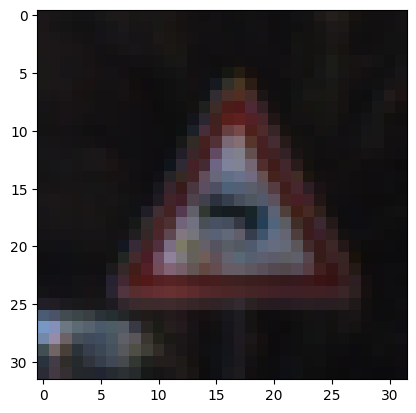

In [ ]:
# Make sure that data and label makes sense
# Selecting a random input data and visualizing it

i = np.random.randint(1, len(x_train))
plt.imshow(x_train[i])
y_train[i]

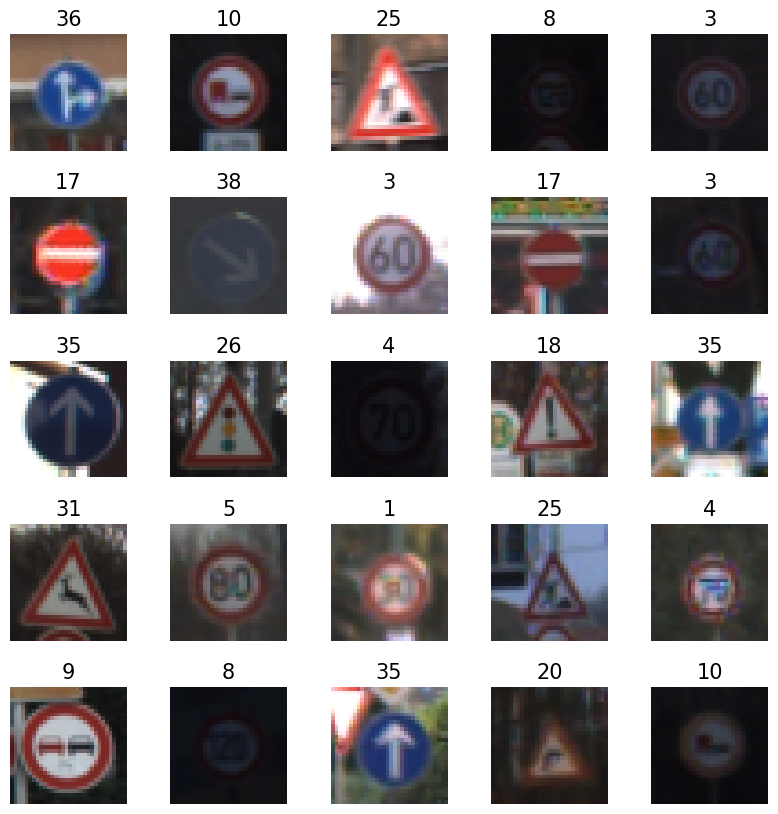

In [ ]:
# Lets view more images in a grid format
# Define dimesions of plot grid (Width and length)
W_grid = 5 
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10, 10))
axes = axes.ravel() # Flatten the 5 * 5 matrix into 25 array
n_training = len(x_train) # Length of training dataset

# For loop to create a grid for us
for i in np.arange(0, W_grid * L_grid):
    # Select a random number from 0 to n_training
    index = np.random.randint(0, n_training)
    
    # Read and display an image with selected index
    axes[i].imshow(x_train[index])
    axes[i].set_title(y_train[index], fontsize = 15)
    
    # Clearing the axis off to visualize more clearly
    axes[i].axis('off') 
    
# Create spacing bet images
plt.subplots_adjust(hspace = 0.4)

## Dataloader

In [ ]:
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

x_valid = torch.FloatTensor(x_valid)
y_valid = torch.LongTensor(y_valid)

x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [ ]:
x_train = x_train / 255
x_test = x_test / 255
x_valid = x_valid / 255

In [ ]:
x_train = torch.permute(x_train, (0, 3, 1, 2))
x_valid = torch.permute(x_valid, (0, 3, 1, 2))
x_test = torch.permute(x_test, (0, 3, 1, 2))

In [ ]:
x_train.shape

torch.Size([34799, 3, 32, 32])

In [ ]:
train_data = TensorDataset(x_train , y_train)
valid_data = TensorDataset(x_valid , y_valid)
test_data = TensorDataset(x_test , y_test)

train_loader = DataLoader(train_data , 128 , shuffle = True)
valid_loader = DataLoader(valid_data , 128 , shuffle = False)
test_loader = DataLoader(test_data , 128 , shuffle = False)

In [ ]:
x , y = next(iter(train_loader))
print(x.shape, y.shape)
y

torch.Size([128, 3, 32, 32]) torch.Size([128])


tensor([14,  3, 38, 16,  5,  3,  5, 18,  5,  4,  1,  3,  9,  5,  3, 24, 26, 25,
        22,  7,  5, 40, 30, 23,  2,  3,  5, 25, 10, 25, 34,  4, 30, 14,  3,  4,
         5,  7, 32, 17,  2, 38, 13,  4, 13, 37, 11, 41,  8,  7,  4,  0, 31,  8,
        42, 28,  3,  9, 18, 23, 10,  7, 12, 15, 31, 38,  2,  2, 13, 25, 13,  1,
        31,  5,  8,  2, 12, 20, 41, 18, 12, 12, 33, 18,  1, 34,  2, 26,  2, 33,
        20, 25, 18,  5, 33, 18,  2, 17, 12, 14, 38, 27, 12, 28, 23, 23, 15, 11,
        13, 18, 12, 23, 23,  7,  7, 34,  4, 29, 23,  1,  3,  3, 23,  3, 10, 10,
        11,  1])

# **Model**

## Custom CNN Model

In [ ]:
def conv3x3_bn_af(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
  return module

In [ ]:
def CNN():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          conv3x3_bn_af(64, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          conv3x3_bn_af(128, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          conv3x3_bn_af(256, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          conv3x3_bn_af(512, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 43) # classifier
                      )

  return network

In [ ]:
model = CNN()

In [ ]:
model(torch.randn(10 , 3 , 28 , 28)).shape

torch.Size([10, 43])

## Count param

In [ ]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [ ]:
num_params(model)

4.711275

# **Device**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

# **Loss & Optimizer** 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters() , lr = 0.01)

# **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
num_cls = 43

# **Functions**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=num_cls).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg, 
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=num_cls).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      
      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# check forward path

Calculate loss for one batch

In [ ]:
x_batch , y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs , y_batch.to(device))
print(loss)

tensor(3.7488, device='cuda:0', grad_fn=<NllLossBackward0>)


# train more epochs

In [ ]:
model = CNN().to(device)

In [ ]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(model.parameters() , lr = lr , weight_decay = wd)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 272/272 [00:11<00:00, 24.05batch/s, accuracy=34.2, loss=2.52]


Valid: Loss = 2.024, Acc = 0.4132



Epoch 1: 100%|██████████| 272/272 [00:11<00:00, 24.30batch/s, accuracy=68, loss=1.25]


Valid: Loss = 1.007, Acc = 0.7409



Epoch 2: 100%|██████████| 272/272 [00:13<00:00, 20.57batch/s, accuracy=89.2, loss=0.532]


Valid: Loss = 0.5365, Acc = 0.8857



Epoch 3: 100%|██████████| 272/272 [00:11<00:00, 24.16batch/s, accuracy=96.9, loss=0.238]


Valid: Loss = 0.5362, Acc = 0.8626



Epoch 4: 100%|██████████| 272/272 [00:11<00:00, 24.36batch/s, accuracy=99.2, loss=0.121]


Valid: Loss = 0.3222, Acc = 0.9281



Epoch 5: 100%|██████████| 272/272 [00:11<00:00, 24.41batch/s, accuracy=99.8, loss=0.0701]


Valid: Loss = 0.2434, Acc = 0.947



Epoch 6: 100%|██████████| 272/272 [00:11<00:00, 24.52batch/s, accuracy=99.9, loss=0.0467]


Valid: Loss = 0.2192, Acc = 0.9509



Epoch 7: 100%|██████████| 272/272 [00:11<00:00, 24.41batch/s, accuracy=100, loss=0.0334]


Valid: Loss = 0.1943, Acc = 0.9572



Epoch 8: 100%|██████████| 272/272 [00:11<00:00, 24.40batch/s, accuracy=100, loss=0.0254]


Valid: Loss = 0.1896, Acc = 0.9584



Epoch 9: 100%|██████████| 272/272 [00:11<00:00, 24.41batch/s, accuracy=100, loss=0.021]


Valid: Loss = 0.1792, Acc = 0.9589



## **Plot**

### Accuracy

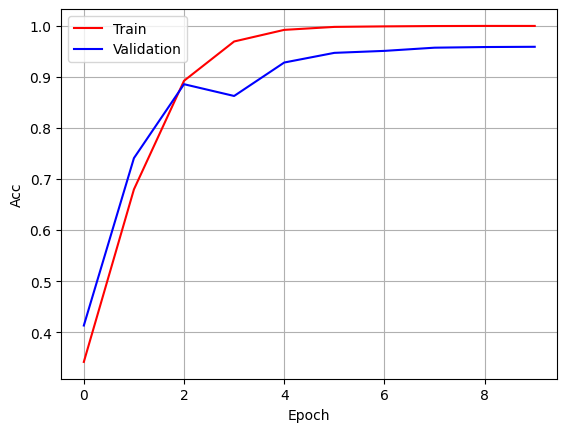

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

### Loss

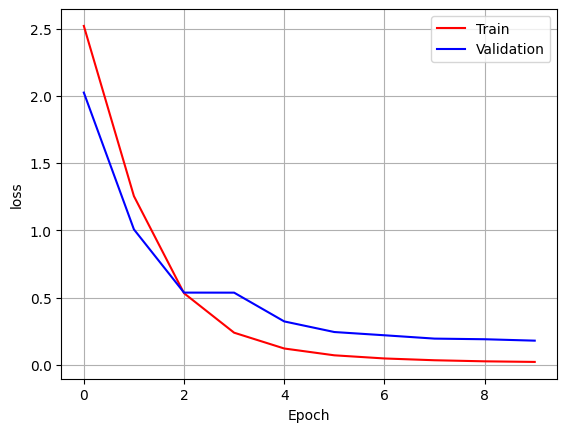

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [ ]:
x , y = next(iter(valid_loader))
print(x.shape, y.shape)
y

torch.Size([128, 3, 32, 32]) torch.Size([128])


tensor([41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
        41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 31, 31, 31, 31, 31, 31,
        31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
        31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
        31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
        31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
        31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 36, 36, 36, 36, 36, 36,
        36, 36])

In [ ]:
def calculate_performance(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        device: torch.device,
        class_names,
        title: str) :
    model.eval()

    y_pred = []
    y_true = []
    test_acc = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            output = (torch.max(torch.exp(test_pred_logits), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = y.data.cpu().numpy()
            y_true.extend(labels)

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_acc = test_acc / len(dataloader)
    cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    df_cm = pd.DataFrame(cf_matrix, index=[i for i in class_names],
                         columns=[i for i in class_names])
    plt.figure(figsize=(12, 7))
    plt.title(title)
    sns.heatmap(df_cm, annot=True)
    plt.show()

    return test_acc, f1, precision, recall

In [ ]:
class_names = torch.unique(y_train, dim=0, sorted=True).tolist()

# calculate_performance

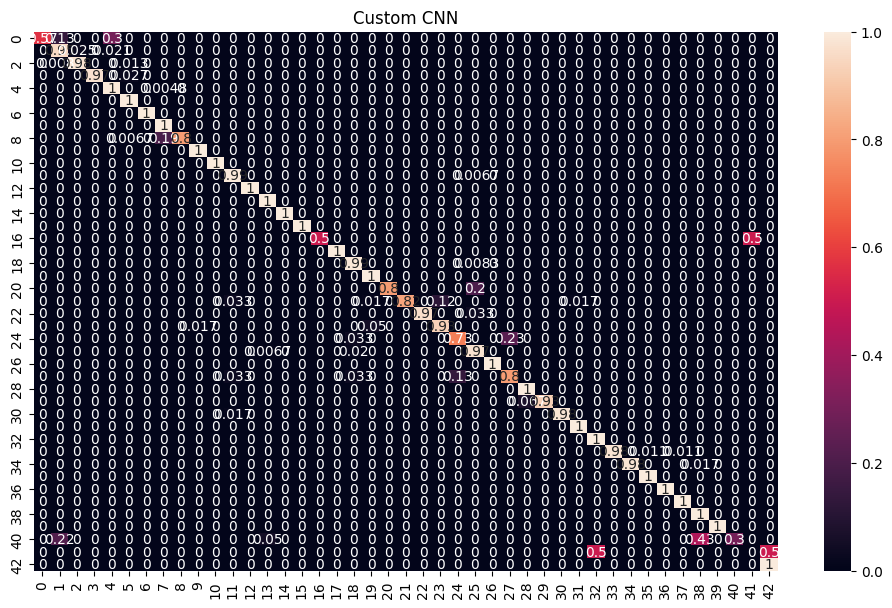

Accuracy = 0.9498614532019705, f1 score = 0.9071608886240266, precision = 0.9295657625461706, recall = 0.905922849760059


In [ ]:
acc, f1, precision, recall = calculate_performance(model, 
                                                  valid_loader, 
                                                  device, 
                                                  class_names, 
                                                  "Custom CNN")
print(f"Accuracy = {acc}, f1 score = {f1}, precision = {precision}, recall = {recall}")

# --- RESNET ---

## Resnet-18

In [ ]:
from torchvision.models import resnet18

In [ ]:
model = resnet18()
model.fc = nn.Linear(512, 43)
model = model.to(device)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Count param

In [ ]:
num_params(model)

11.198571

# **Loss & Optimizer** 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters() , lr = 0.01)

In [ ]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(model.parameters() , lr = lr , weight_decay = wd)

# train more epochs

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 272/272 [00:07<00:00, 34.57batch/s, accuracy=51.7, loss=1.83]


Valid: Loss = 1.518, Acc = 0.5468



Epoch 1: 100%|██████████| 272/272 [00:07<00:00, 36.38batch/s, accuracy=86.8, loss=0.519]


Valid: Loss = 1.079, Acc = 0.6752



Epoch 2: 100%|██████████| 272/272 [00:07<00:00, 35.50batch/s, accuracy=95.3, loss=0.212]


Valid: Loss = 0.9546, Acc = 0.7203



Epoch 3: 100%|██████████| 272/272 [00:07<00:00, 34.95batch/s, accuracy=98.1, loss=0.0996]


Valid: Loss = 0.8711, Acc = 0.7478



Epoch 4: 100%|██████████| 272/272 [00:07<00:00, 36.22batch/s, accuracy=99.1, loss=0.0587]


Valid: Loss = 0.8986, Acc = 0.7557



Epoch 5: 100%|██████████| 272/272 [00:08<00:00, 30.51batch/s, accuracy=99.6, loss=0.0366]


Valid: Loss = 0.8456, Acc = 0.7714



Epoch 6: 100%|██████████| 272/272 [00:08<00:00, 33.69batch/s, accuracy=99.8, loss=0.0223]


Valid: Loss = 0.8129, Acc = 0.7793



Epoch 7: 100%|██████████| 272/272 [00:07<00:00, 36.65batch/s, accuracy=99.9, loss=0.0162]


Valid: Loss = 0.8183, Acc = 0.7795



Epoch 8: 100%|██████████| 272/272 [00:07<00:00, 35.32batch/s, accuracy=100, loss=0.0113]


Valid: Loss = 0.8068, Acc = 0.7842



Epoch 9: 100%|██████████| 272/272 [00:07<00:00, 35.64batch/s, accuracy=100, loss=0.00914]


Valid: Loss = 0.8025, Acc = 0.7867



## **Plot**

### Accuracy

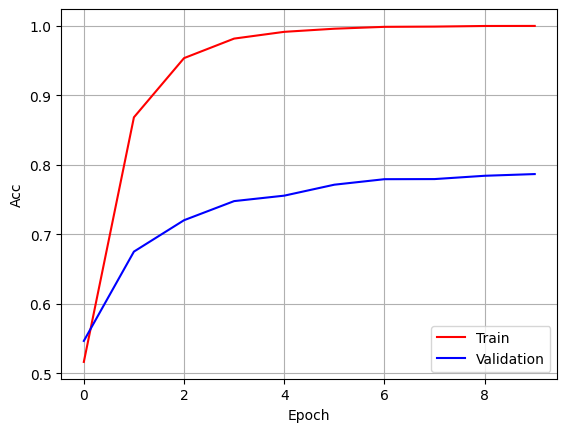

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

### Loss

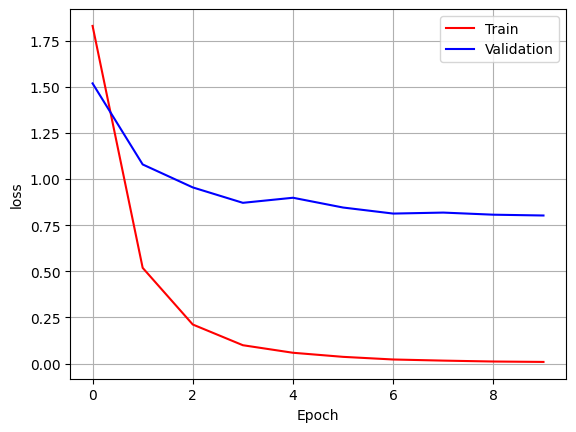

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# calculate_performance

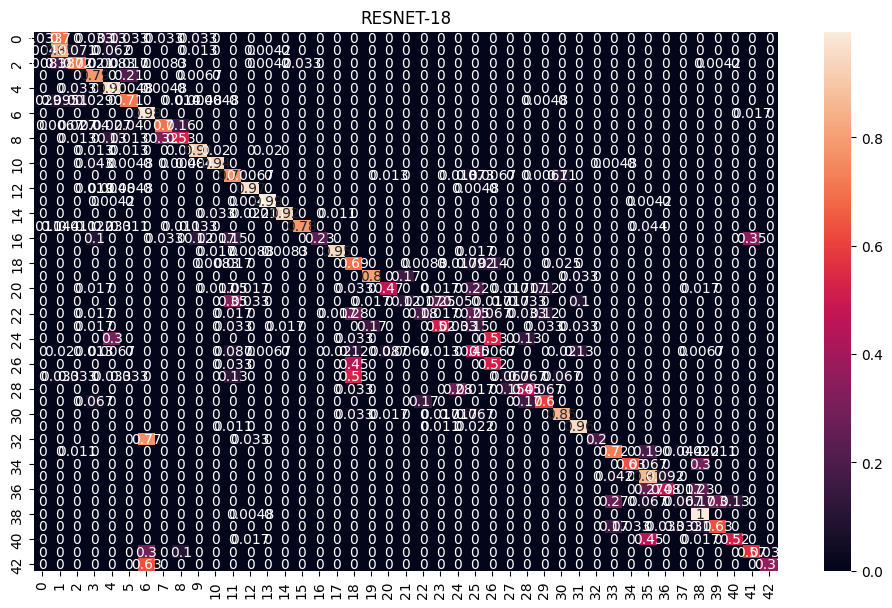

Accuracy = 0.7345520320197044, f1 score = 0.6149846814013256, precision = 0.6755967125736525, recall = 0.6149815430047988


In [ ]:
acc, f1, precision, recall = calculate_performance(model, 
                                                  valid_loader, 
                                                  device, 
                                                  class_names, 
                                                  "RESNET-18")
print(f"Accuracy = {acc}, f1 score = {f1}, precision = {precision}, recall = {recall}")

# --- Efficcient net ---

In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=b91e63af9efc4d9856b4c1ea1fda9b58b59168de6902fe0b7f14a2fcf9809c6d
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch


## Efficientnet-B0

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [ ]:
model._fc = nn.Linear(1280, 43)
model = model.to(device)

In [ ]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

## Count param

In [ ]:
num_params(model)

4.062631

# **Loss & Optimizer** 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters() , lr = 0.01)

In [ ]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(model.parameters() , lr = lr , weight_decay = wd)

# train more epochs

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 272/272 [00:15<00:00, 17.06batch/s, accuracy=29.7, loss=2.87]


Valid: Loss = 2.332, Acc = 0.4226



Epoch 1: 100%|██████████| 272/272 [00:18<00:00, 14.71batch/s, accuracy=58, loss=1.6]


Valid: Loss = 1.441, Acc = 0.5918



Epoch 2: 100%|██████████| 272/272 [00:15<00:00, 17.12batch/s, accuracy=71.5, loss=1.03]


Valid: Loss = 1.075, Acc = 0.6759



Epoch 3: 100%|██████████| 272/272 [00:15<00:00, 17.14batch/s, accuracy=80.1, loss=0.698]


Valid: Loss = 0.8853, Acc = 0.7302



Epoch 4: 100%|██████████| 272/272 [00:15<00:00, 17.00batch/s, accuracy=86.2, loss=0.488]


Valid: Loss = 0.7789, Acc = 0.7603



Epoch 5: 100%|██████████| 272/272 [00:16<00:00, 16.72batch/s, accuracy=89.9, loss=0.355]


Valid: Loss = 0.6653, Acc = 0.7978



Epoch 6: 100%|██████████| 272/272 [00:20<00:00, 13.51batch/s, accuracy=92.3, loss=0.272]


Valid: Loss = 0.6047, Acc = 0.8197



Epoch 7: 100%|██████████| 272/272 [00:15<00:00, 17.20batch/s, accuracy=94.1, loss=0.21]


Valid: Loss = 0.5737, Acc = 0.8314



Epoch 8: 100%|██████████| 272/272 [00:15<00:00, 17.28batch/s, accuracy=95.3, loss=0.17]


Valid: Loss = 0.5487, Acc = 0.841



Epoch 9: 100%|██████████| 272/272 [00:15<00:00, 17.18batch/s, accuracy=95.8, loss=0.146]


Valid: Loss = 0.5122, Acc = 0.8526



## **Plot**

### Accuracy

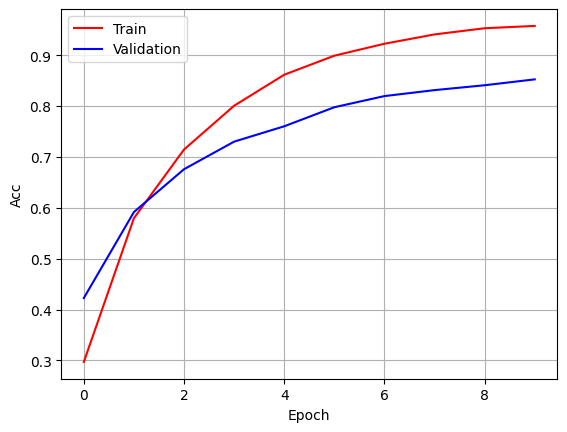

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

### Loss

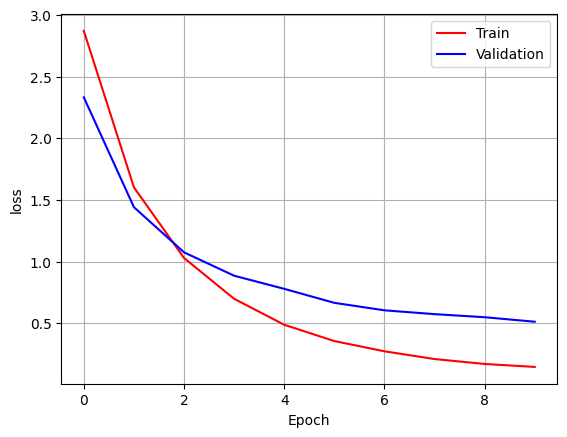

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# calculate_performance

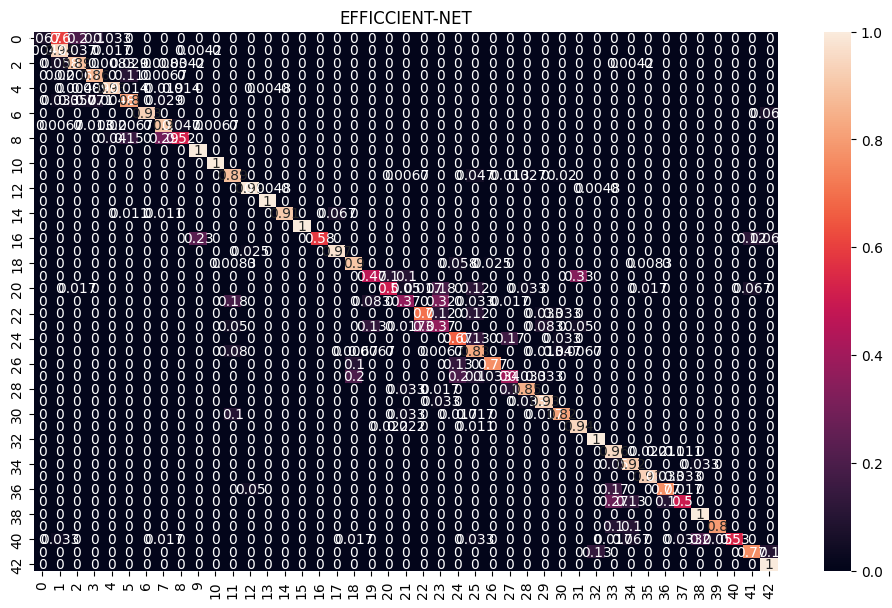

Accuracy = 0.8591440886699507, f1 score = 0.7869784355245356, precision = 0.8149865697442201, recall = 0.7877445551864156


In [ ]:
acc, f1, precision, recall = calculate_performance(model, 
                                                  valid_loader, 
                                                  device, 
                                                  class_names, 
                                                  "EFFICCIENT-NET")
print(f"Accuracy = {acc}, f1 score = {f1}, precision = {precision}, recall = {recall}")

# --- GRAY-SCALE ---

In [ ]:
# Converting image from color to grayscale
# Dividing red, green and blue pixels so we divide by 3

x_train_gray = np.sum(x_train/3, axis = 3, keepdims = True)
x_test_gray = np.sum(x_test/3, axis = 3, keepdims = True)
x_valid_gray = np.sum(x_valid/3, axis = 3, keepdims = True)

In [ ]:
x_train_gray.shape 

(34799, 32, 32, 1)

In [ ]:
# Normalize the images

x_train_gray_norm = (x_train_gray - 128)/128
x_test_gray_norm = (x_test_gray - 128)/128
x_valid_gray_norm = (x_valid_gray - 128)/128

## Visualize

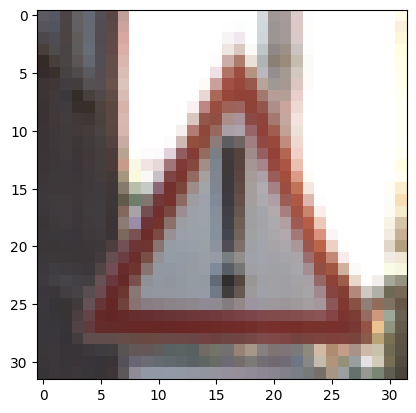

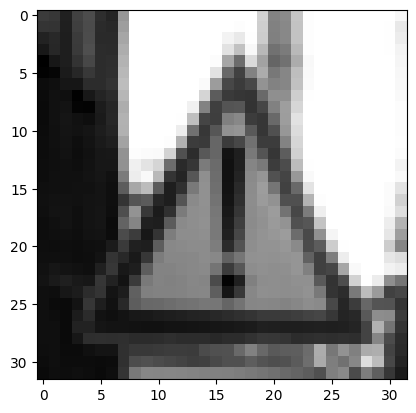

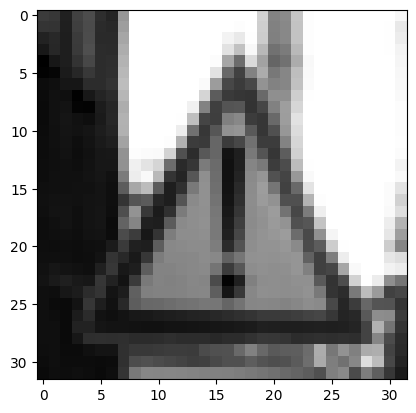

In [ ]:
i = random.randint(1, len(x_train_gray))
plt.imshow(x_train[i]) # Original image
plt.figure()
plt.imshow(x_train_gray[i].squeeze(), cmap='gray') # Gray scale image
plt.figure()
plt.imshow(x_train_gray_norm[i].squeeze(), cmap='gray') # Normalised image

## Dataloader

In [ ]:
x_train = torch.FloatTensor(x_train_gray_norm)
y_train = torch.LongTensor(y_train)

x_valid = torch.FloatTensor(x_valid_gray_norm)
y_valid = torch.LongTensor(y_valid)

x_test = torch.FloatTensor(x_test_gray_norm)
y_test = torch.LongTensor(y_test)

In [ ]:
x_train = torch.permute(x_train, (0, 3, 1, 2))
x_valid = torch.permute(x_valid, (0, 3, 1, 2))
x_test = torch.permute(x_test, (0, 3, 1, 2))

In [ ]:
x_train.shape

torch.Size([34799, 1, 32, 32])

# train more epochs

In [ ]:
model = CNN().to(device)

In [ ]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(model.parameters() , lr = lr , weight_decay = wd)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model, 
                                                 train_loader, 
                                                 loss_fn, 
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)
  
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)
  
  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 272/272 [00:11<00:00, 22.78batch/s, accuracy=34.4, loss=2.51]


Valid: Loss = 1.994, Acc = 0.4415



Epoch 1: 100%|██████████| 272/272 [00:11<00:00, 24.44batch/s, accuracy=67.4, loss=1.26]


Valid: Loss = 1.056, Acc = 0.7226



Epoch 2: 100%|██████████| 272/272 [00:11<00:00, 24.46batch/s, accuracy=88.7, loss=0.554]


Valid: Loss = 0.6265, Acc = 0.8489



Epoch 3: 100%|██████████| 272/272 [00:11<00:00, 24.01batch/s, accuracy=96.7, loss=0.25]


Valid: Loss = 0.4169, Acc = 0.9098



Epoch 4: 100%|██████████| 272/272 [00:11<00:00, 24.35batch/s, accuracy=99.2, loss=0.128]


Valid: Loss = 0.3144, Acc = 0.934



Epoch 5: 100%|██████████| 272/272 [00:11<00:00, 24.34batch/s, accuracy=99.8, loss=0.0735]


Valid: Loss = 0.3027, Acc = 0.934



Epoch 6: 100%|██████████| 272/272 [00:11<00:00, 24.18batch/s, accuracy=99.9, loss=0.0483]


Valid: Loss = 0.2462, Acc = 0.9474



Epoch 7: 100%|██████████| 272/272 [00:11<00:00, 23.26batch/s, accuracy=100, loss=0.0335]


Valid: Loss = 0.2158, Acc = 0.9535



Epoch 8: 100%|██████████| 272/272 [00:11<00:00, 23.81batch/s, accuracy=100, loss=0.0253]


Valid: Loss = 0.1965, Acc = 0.9565



Epoch 9: 100%|██████████| 272/272 [00:12<00:00, 22.02batch/s, accuracy=99.9, loss=0.0221]


Valid: Loss = 0.1938, Acc = 0.9569



## **Plot**

### Accuracy

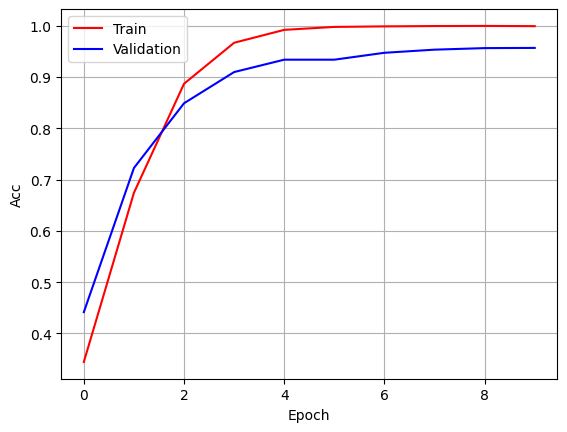

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

### Loss

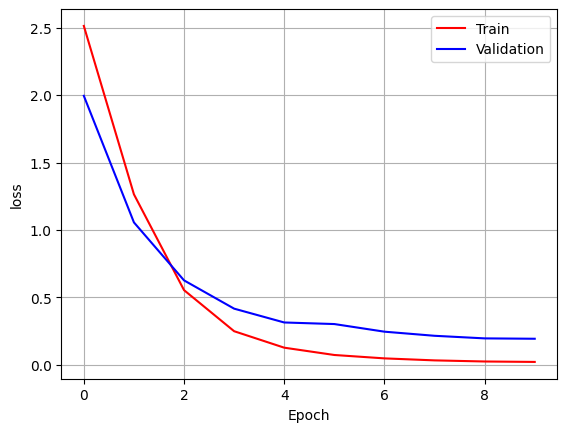

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# calculate_performance

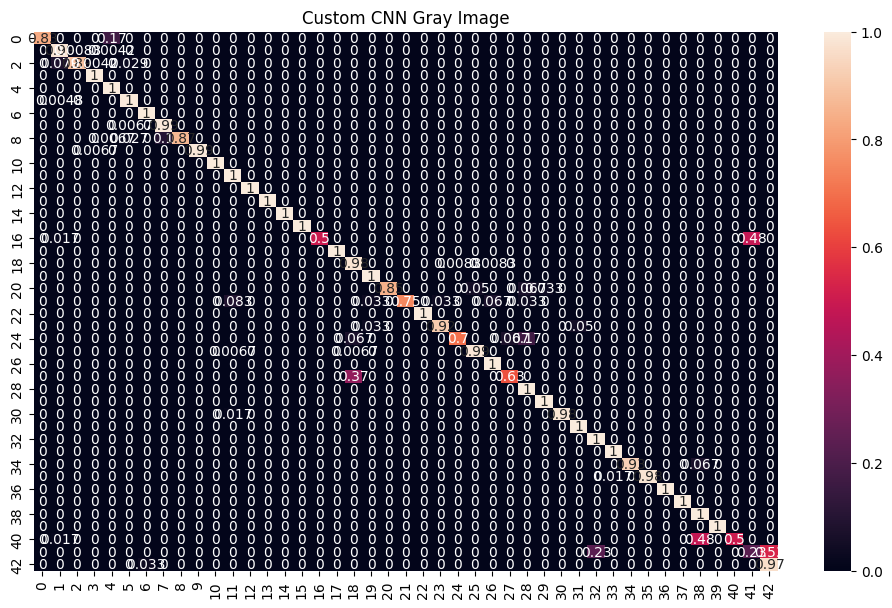

Accuracy = 0.954371921182266, f1 score = 0.9213549921768054, precision = 0.9395299988337812, recall = 0.9180675526024363


In [ ]:
acc, f1, precision, recall = calculate_performance(model, 
                                                  valid_loader, 
                                                  device, 
                                                  class_names, 
                                                  "Custom CNN Gray Image")
print(f"Accuracy = {acc}, f1 score = {f1}, precision = {precision}, recall = {recall}")